In [1]:
import json
'''
Read reviews from a JSON-formatted file into an array.
'''
lines = [];
num_pos = 0; num_neg = 0; num_total = 75000;

with open('yelp_academic_dataset_review.json', 'r') as f:
    for line in f:
        if (len(lines) >= (num_total * 2)):
            break;
        
        json_info = json.loads(line);
        
        if json_info['stars'] > 3:
            if num_pos > num_total:
                continue;
            num_pos = num_pos + 1;
        elif json_info['stars'] < 3:
            if num_neg > num_total:
                continue;
            num_neg = num_neg + 1;
        else:
            continue;
            
        lines.append(json.loads(line));

'''
Separate line data into reviews and labels
'''
reviews = [line['text'] for line in lines];

stars = [line['stars'] for line in lines];
labels = ['1' if star > 3 else '0' for star in stars];

In [2]:
import string
import re
'''
Clean each document by removing unnecesary characters and splitting by space.
'''
def clean_document(doco):
    punctuation = string.punctuation + '\n\n';
    punc_replace = ''.join([' ' for s in punctuation]);
    doco_clean = doco.replace('-', ' ');
    doco_alphas = re.sub(r'\W +', '', doco_clean)
    trans_table = str.maketrans(punctuation, punc_replace);
    doco_clean = ' '.join([word.translate(trans_table) for word in doco_alphas.split(' ')]);
    doco_clean = doco_clean.split(' ');
    doco_clean = [word.lower() for word in doco_clean if len(word) > 0];
    
    return doco_clean;

# Generate a cleaned reviews array from original review texts
review_cleans = [clean_document(doc) for doc in reviews];
sentences = [' '.join(r) for r in review_cleans]

/var/folders/n9/n5041f191wnfkmgzsv4_xtqm0000gn/T/ipykernel_20111/4097078313.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  text_sequences = np.array(tokenizer.texts_to_sequences(sentences));


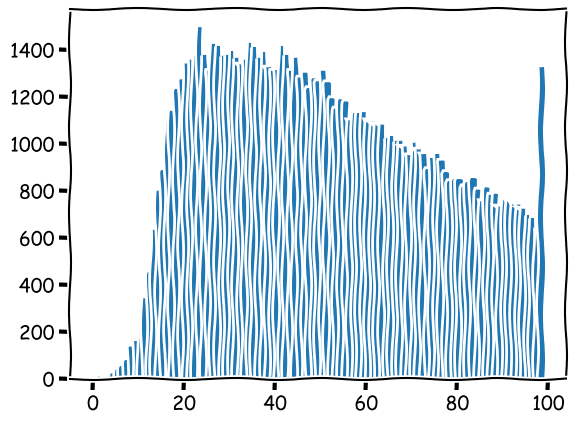

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt 
import numpy as np

# Use a Keras Tokenizer and fit on the sentences

tokenizer = Tokenizer();
tokenizer.fit_on_texts(sentences);
text_sequences = np.array(tokenizer.texts_to_sequences(sentences));
sequence_dict = tokenizer.word_index;
word_dict = dict((num, val) for (val, num) in sequence_dict.items());

# We get a map of encoding-to-word in sequence_dict

# Generate encoded reviews
reviews_encoded = [];
for i,review in enumerate(review_cleans):
    reviews_encoded.append([sequence_dict[x] for x in review]);
    
# Plot a Histogram of length of reviews
lengths = [len(x) for x in reviews_encoded];
with plt.xkcd():
    plt.hist(lengths, bins=range(100))

In [4]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Truncate and Pad reviews at a Maximum cap of 60 words.
max_cap = 60;
X = pad_sequences(reviews_encoded, maxlen=max_cap, truncating='post')

# Obtain a One-hot Y array for each review label.
Y = np.array([[0,1] if '0' in label else [1,0] for label in labels])

# Get a randomized sequence of positions to shuffle reviews
np.random.seed(1024);
random_posits = np.arange(len(X))
np.random.shuffle(random_posits);

# Shuffle X and Y
X = X[random_posits];
Y = Y[random_posits];

# Divide the reviews into Training, Dev, and Test data.
train_cap = int(0.85 * len(X));
dev_cap = int(0.93 * len(X));

X_train, Y_train = X[:train_cap], Y[:train_cap];
X_dev, Y_dev = X[train_cap:dev_cap], Y[train_cap:dev_cap];
X_test, Y_test = X[dev_cap:], Y[dev_cap:]

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential();
model.add(Embedding(len(word_dict), max_cap, input_length=max_cap));
model.add(LSTM(100, return_sequences=True));
model.add(LSTM(100));
model.add(Dense(100, activation='relu'));
model.add(Dense(2, activation='softmax'));
print(model.summary());

optimizer = Adam(lr=0.001, decay=0.0001);
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# fit model
model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_dev, Y_dev))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 60, 60)            35684700  
                                                                 
 lstm (LSTM)                 (None, 60, 100)           64400     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 35,839,802
Trainable params: 35,839,802
Non-trainable params: 0
_________________________________________________________________
None


/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
915/997 [==========================>...] - ETA: 50s - loss: 0.3027 - accuracy: 0.8710

InvalidArgumentError: Graph execution error:

Detected at node 'sequential/embedding/embedding_lookup' defined at (most recent call last):
    File "/Users/aman/opt/anaconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/aman/opt/anaconda3/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/aman/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/Users/aman/opt/anaconda3/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/Users/aman/opt/anaconda3/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/n9/n5041f191wnfkmgzsv4_xtqm0000gn/T/ipykernel_20111/3869914961.py", line 16, in <module>
      model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_dev, Y_dev))
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/sequential.py", line 374, in call
      return super(Sequential, self).call(inputs, training=training, mask=mask)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/aman/opt/anaconda3/lib/python3.8/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'sequential/embedding/embedding_lookup'
indices[94,26] = 594745 is not in [0, 594745)
	 [[{{node sequential/embedding/embedding_lookup}}]] [Op:__inference_train_function_5694]